In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import glob
import pandas as pd
from collections import OrderedDict

In [2]:
#model = "multitask-knn-neuraljacobian-custom"
model = "knn-neuraljacobian-custom"
directories = glob.glob('.experiments/multi-point-tuning-knn-neural-jac/{}/*/result*.pth'.format(model))

#load each 
results = {}
seed = 0
is_one_model = False
for pth in directories:
    dt = pth.split('/')[-1].split('-dt-')[-1].split('-')[0]
    algorithm = pth.split('/')[2] + '-' + dt
    k = pth.split('/')[-2].split('-k-')[-1].split('-')[0]
    algorithm = algorithm + "-k-" + k
    result = torch.load(pth)
    if algorithm in results and not is_one_model:
        start = len(results[algorithm])
        end = len(results[algorithm]) + len(result)
        j = 0
        for i in range(start, end):
            results[algorithm][i] = result[j]
            j += 1        
    elif algorithm in results and is_one_model:
        results[algorithm + "-" + str(seed)] = result
        seed += 1
    else:
        results[algorithm] = result
    

In [3]:
results.keys()

dict_keys(['knn-neuraljacobian-custom-results-k-8', 'knn-neuraljacobian-custom-results-k-16', 'knn-neuraljacobian-custom-results-k-32', 'knn-neuraljacobian-custom-results-k-10', 'knn-neuraljacobian-custom-results-k-64', 'knn-neuraljacobian-custom-results-k-2', 'knn-neuraljacobian-custom-results-k-4'])

In [5]:
knn = [2, 4, 8, 16, 32, 64]
regular = [("knn-neuraljacobian-custom-results-k-" + str(k), "k = " + str(k)) for k in knn]
multitask = [("multitask-knn-neuraljacobian-custom-results-k-" + str(k), "k = " + str(k)) for k in knn]
if model == "knn-neuraljacobian-custom":
    labels = regular
else:
    labels = multitask
print(labels)
labels = OrderedDict(labels)
new_results = []
for label in labels:
    for k in results.keys():
        if label == k:
            print(k, label)
            new_results.append([labels[label], results[k]])
            



[('knn-neuraljacobian-custom-results-k-2', 'k = 2'), ('knn-neuraljacobian-custom-results-k-4', 'k = 4'), ('knn-neuraljacobian-custom-results-k-8', 'k = 8'), ('knn-neuraljacobian-custom-results-k-16', 'k = 16'), ('knn-neuraljacobian-custom-results-k-32', 'k = 32'), ('knn-neuraljacobian-custom-results-k-64', 'k = 64')]
knn-neuraljacobian-custom-results-k-2 knn-neuraljacobian-custom-results-k-2
knn-neuraljacobian-custom-results-k-4 knn-neuraljacobian-custom-results-k-4
knn-neuraljacobian-custom-results-k-8 knn-neuraljacobian-custom-results-k-8
knn-neuraljacobian-custom-results-k-16 knn-neuraljacobian-custom-results-k-16
knn-neuraljacobian-custom-results-k-32 knn-neuraljacobian-custom-results-k-32
knn-neuraljacobian-custom-results-k-64 knn-neuraljacobian-custom-results-k-64


In [6]:
results = new_results

results = OrderedDict(new_results)


In [7]:
results.keys()

odict_keys(['k = 2', 'k = 4', 'k = 8', 'k = 16', 'k = 32', 'k = 64'])

In [8]:
len(results['k = 2'])

1100

# Plot Error Curves
In this section we want to see if our Jacobian estimates with our neural network actually solve the undlerying task of interest (i.e. moving the end effector to some target position)

In [9]:
def collect_eps_errs(result, dim=-1):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            state = v[5] #should be....state
            if dim < 0:
                psn = state[0:12]
                targ = state[-12:]
                mse = np.linalg.norm(targ - psn, 2)
                
            else:
                psn = state[dim]
                targ = state[-12 + dim]
                mse = np.sqrt((targ - psn) ** 2)
            episode_err.append(mse)
        err_over_time.append(episode_err)
    return np.array(err_over_time).T

def plot_mu_sig(data, label=None, axis=1, ax=None,line_stype='b-'):
    samples = np.array(data)
    mean = samples.mean(axis=axis)
    std = samples.std(axis=axis)
    ste = std / np.sqrt(samples.shape[1]) #this is a hack, if axis not == 1, this will break
    
    ax.plot(mean,line_stype, label=label)
    #ax.errorbar(list(range(mean.shape[0])), mean, yerr=std /np.sqrt(samples.shape[0]) , label=label)
    ax.fill_between(list(range(mean.shape[0])), mean + ste, mean - ste, color=line_stype[0], alpha=0.1)

In [10]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time

In [11]:
line_types = [
            ("k = 2", "b|-"),
            ("k = 4", "g--"),
            ("k = 8", "r-d"),
          ("k = 16", "c-."),
          ("k = 32", "m-"),
          ("k = 64", "y:"),
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['k = 2', 'k = 4', 'k = 8', 'k = 16', 'k = 32', 'k = 64'])

96
393
464
147


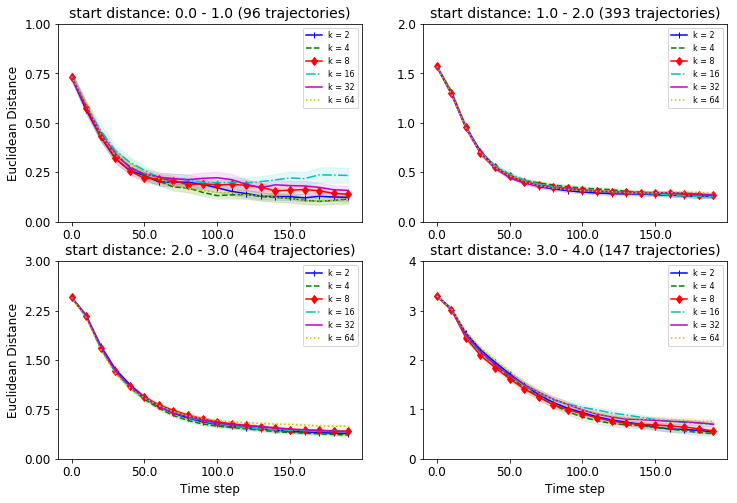

In [12]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE + 2)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
bounds = [0.0, 1.0, 2.0, 3.0, 4.0]
n_plts = len(bounds) - 1
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    num_trajs = 0.0
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        num_trajs = np.sum(to_plot)
        line_type = line_types[algorithm]
        plot_mu_sig(err_over_time[0:200:10, to_plot], label=algorithm, ax=ax, line_stype=line_type)
    
    print(num_trajs)
    ax.get_yaxis().set_ticks(np.linspace(0.0, end, 5))
    ax.legend()
    ax.set_title("start distance: {} - {} ({} trajectories)".format(start, end, num_trajs))
    
    i += 1
    if i == 1 or i == 3:
        ax.set_ylabel("Euclidean Distance")
    
    if i == len(bounds) - 1 or i == 3:
        ax.set_xlabel("Time step")

    ax.set_xticklabels(labels = 20* np.arange(-2.5, 20, 2.5))
        
        
    
plt.savefig('{}_multi_pt_error_curves.pdf'.format(model),bbox_inches = 'tight',
    pad_inches = 0.1) 

# Violin Plots of End Performance

In this section we focus on the performance at the end of each episode. specifically whether or not the target was reached

In [13]:

violin_results = []
for algorithm, result in results.items():
    print(algorithm)
    err_over_time = collect_eps_errs(result, dim=-1)
    violin_results.append([algorithm, err_over_time])
    
violin_results = OrderedDict(violin_results)

k = 2
k = 4
k = 8
k = 16
k = 32
k = 64


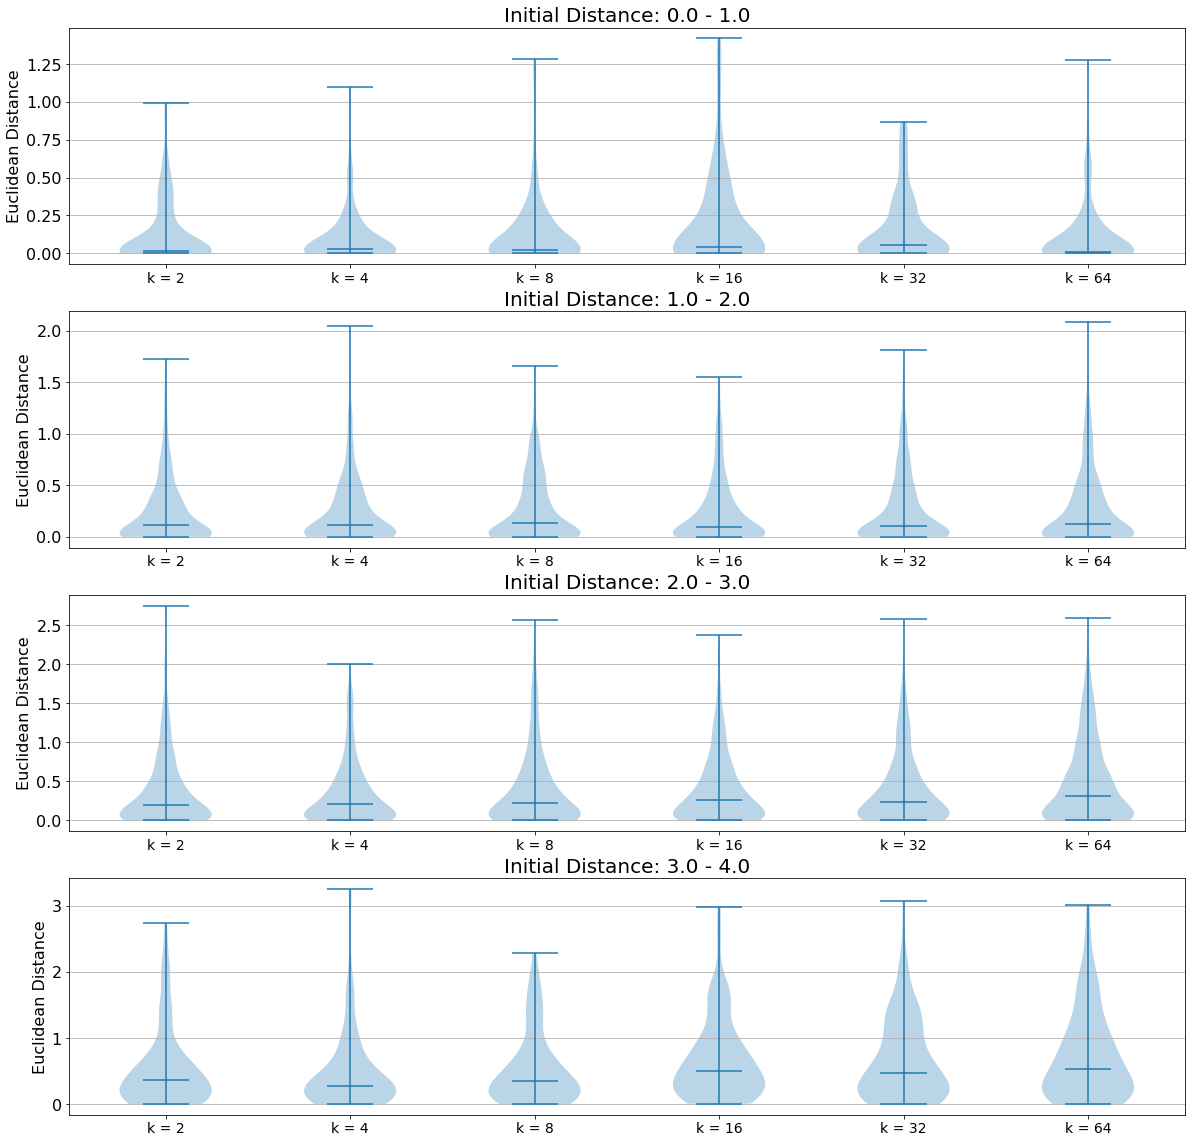

In [14]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig, axs = plt.subplots(4, 1, figsize=(20, 20))


bounds = [0.0, 1.0, 2.0, 3.0, 4.0]
successTable = {}
i = 0
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    end_dists = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        
        percentage = to_plot.sum() / count[-1]
        end_dist = err_over_time[-1, to_plot]  # for delta t between each timestep
        #end_dist = end_dist[to_plot]
        
        
        end_dists.append(end_dist)
        labels.append(algorithm)
    ax = axs[i]
    i+= 1
    ax.violinplot(end_dists, showmeans=False, showmedians=True)
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels([l.format(len(a)) for l, a in zip(labels, end_dists)])
    ax.yaxis.grid(True)
    ax.set_ylabel("Euclidean Distance")
    ax.set_title("Initial Distance: {} - {}".format(low, high))

plt.savefig('{}_multi_pt_violion_end_position.pdf'.format(model),bbox_inches = 'tight',
    pad_inches = 0.1)   

# These are just tables of statistics from the trajectories 
The basic question is whether or not they reached the target. 
We considered the target reached by some threshold


In [15]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time


In [16]:

successTable = {}
thresh=0.05
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        to_plot = np.logical_and(to_plot, err_over_time[-1,:] <= thresh)

        percentage = to_plot.sum() / count[-1] * 100.0 #so it's between 0 - 100%

        if not algorithm in successTable:
            successTable[algorithm] = {"{}m - {}m".format(low,high): percentage}
        else:
            successTable[algorithm]["{}m - {}m".format(low,high)] = percentage
    
        labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    succeses = (err_over_time[-1,:] <= thresh)
    percentage = succeses.sum() / err_over_time.shape[1] * 100.0 #so it's between 0 - 100%
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in successTable:
            successTable[algorithm] = {"Overall": percentage}
    else:
        successTable[algorithm]["Overall"] = percentage
    
successTable = pd.DataFrame.from_dict(successTable).round(2).transpose()
successTable

,0.0m - 1.0m,1.0m - 2.0m,2.0m - 3.0m,3.0m - 4.0m,Overall
k = 16,52.08,40.97,25.22,6.12,30.64
k = 2,61.46,41.22,30.82,16.33,35.27
k = 32,48.96,41.73,26.51,12.93,32.09
k = 4,63.54,38.68,29.53,12.93,33.55
k = 64,63.54,41.22,25.65,10.20,32.45
k = 8,57.29,39.95,29.53,16.33,33.91


In [17]:
successesTable = {}
count = []
step_size = 0.001
max_thresh = 0.25
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        #ij_b = iJ_bounds["{}-{}".format(low,high)]
        
        #step_size = (ij_b["high"] - ij_b["low"] ) / 100
        #range_to_thresh = np.arange(ij_b["low"], ij_b["high"] + step_size, step_size )
        range_to_thresh = np.arange(0, max_thresh, 0.001)
        for thresh in range_to_thresh:
            success = np.logical_and(to_plot, err_over_time[-1,:] <= thresh)

            percentage = success.sum() / count[-1] * 100.0 #so it's between 0 - 100%
            key = "{} - {}".format(low,high)
            if key == "{} - {}".format(bounds[0], bounds[-1]):
                key = "Overall"
            if not algorithm in successesTable:
                successesTable[algorithm] = {key: [percentage]}
            elif  key not in successesTable[algorithm] :
                successesTable[algorithm][key] = [percentage]
            else:
                successesTable[algorithm][key].append(percentage)
            


In [18]:
successes_auc_success_thresh = {}

num_thresh = len(np.arange(0, max_thresh, 0.001))
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:

    i += 1
    key = "{} - {}".format(low, high)
    if key == "{} - {}".format(bounds[0], bounds[-1]):
        key = "Overall"
    #ij_b = iJ_bounds["{}-{}".format(low,high)]
    #step_size = (ij_b["high"] - ij_b["low"] ) / num_thresh
    for algorithm in successesTable.keys():
        percentages = successesTable[algorithm][key]
        if not algorithm in successes_auc_success_thresh:
            successes_auc_success_thresh[algorithm] = {key: sum(percentages) / num_thresh }
        elif  key not in successes_auc_success_thresh[algorithm] :
            successes_auc_success_thresh[algorithm][key] = sum(percentages) / num_thresh

successes_auc_success_thresh_table = pd.DataFrame.from_dict(successes_auc_success_thresh).round(2).transpose()
successes_auc_success_thresh_table

,0.0 - 1.0,1.0 - 2.0,2.0 - 3.0,3.0 - 4.0,Overall
k = 16,57.03,50.19,34.64,15.75,39.63
k = 2,68.02,49.51,39.61,26.00,43.81
k = 32,59.88,50.21,34.42,20.46,40.42
k = 4,70.94,49.26,38.87,25.25,43.56
k = 64,71.27,48.54,32.60,18.19,39.75
k = 8,65.42,47.70,37.56,24.14,41.82


In [19]:
line_types = [
            ("k = 2", "b|-"),
            ("k = 4", "g--"),
            ("k = 8", "r-d"),
          ("k = 16", "c-."),
          ("k = 32", "m-"),
          ("k = 64", "y:"),
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['k = 2', 'k = 4', 'k = 8', 'k = 16', 'k = 32', 'k = 64'])

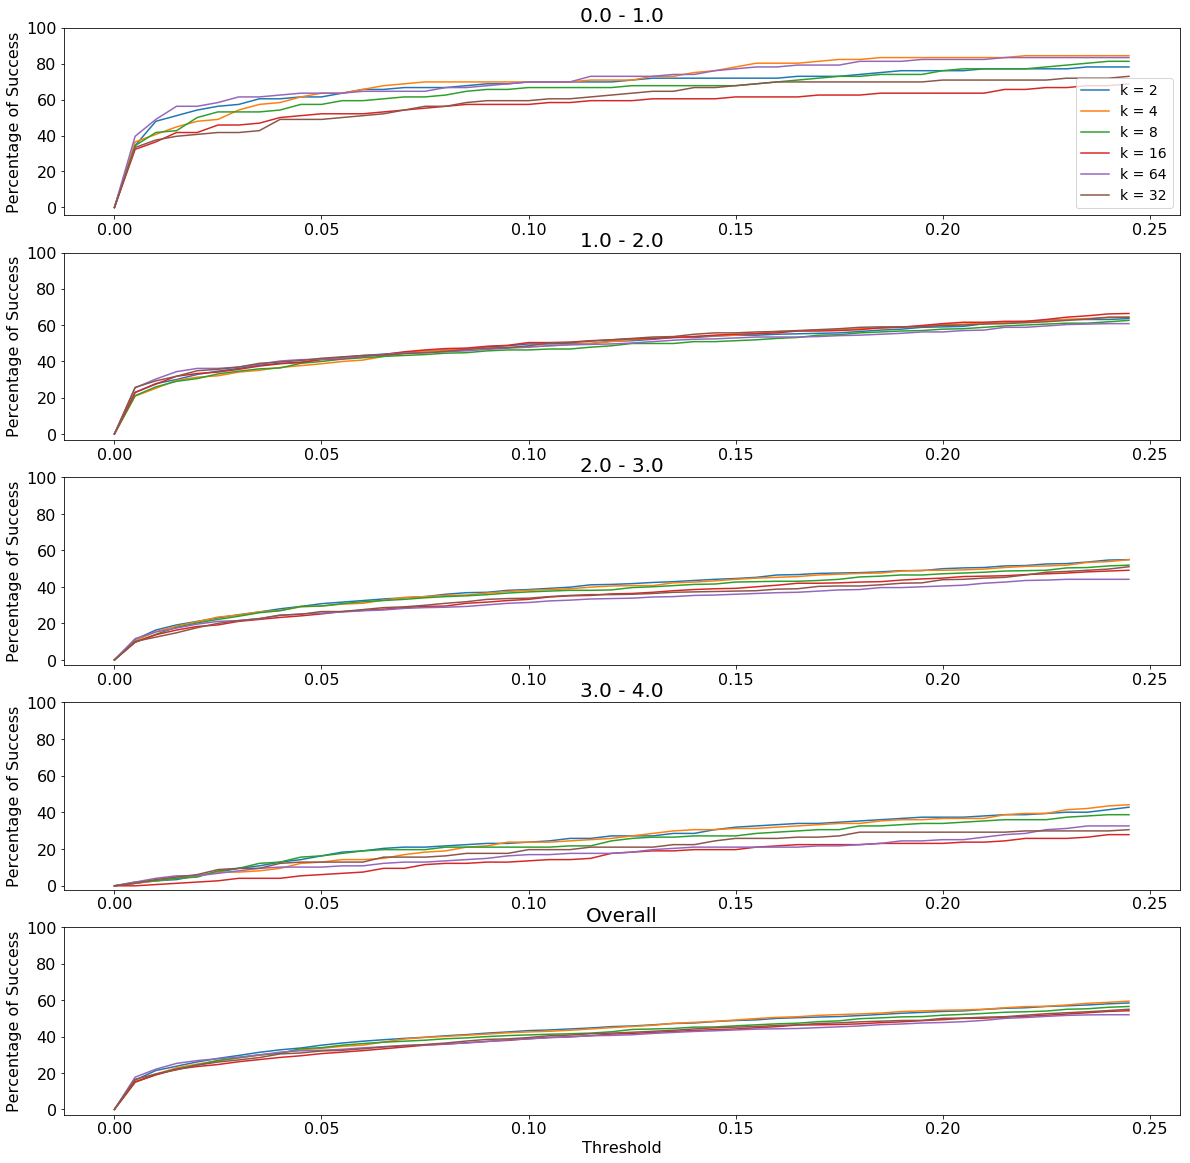

In [20]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig, axs = plt.subplots(5, 1, figsize=(20, 20))

i = 0
num_thresh = len(np.arange(0, max_thresh, 0.001))
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:
    ax = axs[i]
    i += 1
    key = "{} - {}".format(low, high)
    if key == "{} - {}".format(bounds[0], bounds[-1]):
        key = "Overall"
    #ij_b = iJ_bounds["{}-{}".format(low,high)]
    #step_size = (ij_b["high"] - ij_b["low"] ) / 100
    #range_to_thresh = np.arange(ij_b["low"], ij_b["high"], step_size )
    range_to_thresh = np.arange(0, max_thresh, 0.001)
    for algorithm in successesTable.keys():
        result = successesTable[algorithm][key]
        #line_style = line_types[algorithm]
        ax.plot(range_to_thresh[0:-1:5], result[0:-1:5], label=algorithm)# line_style, label=algorithm)
    if i == 1:
        ax.legend()
    ax.set_title(key)
    #ax.set_xticklabels(labels = ["{:.3f}".format(v) for v in np.arange(0 - 0.04166, .25, 0.04166)])
    ax.set_ylabel("Percentage of Success")
    ax.set_yticks([i for i in range(0, 110, 20)])
    if i == len(axs):
        ax.set_xlabel("Threshold")

In [21]:
end_dist_table = {}
end_dist_table_std = {}
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        end_diff = err_over_time[-1,:]
        end_diff = end_diff[to_plot]
        
        
        mu = end_diff.mean()
        std = end_diff.std() / np.sqrt(np.sum(to_plot))
        algorithm = algorithm.split('-results')[0]
        if "global-" in algorithm:
            algorithm = algorithm.split('global-')[-1]
        
        if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"{}m - {}m".format(low,high): mu}
            end_dist_table_std[algorithm] = {"{}m - {}m".format(low,high): std}
        else:
            end_dist_table[algorithm]["{}m - {}m".format(low,high)] = mu
            end_dist_table_std[algorithm]["{}m - {}m".format(low,high)] = std
            
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    end_diff = err_over_time[-1,:]
    mu = end_diff.mean()
    std = end_diff.std()  / np.sqrt(np.sum(to_plot)) #ste
    
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"Overall": mu}
            end_dist_table_std[algorithm] = {"Overall".format(low,high): std}
    else:
        end_dist_table[algorithm]["Overall"] = mu
        end_dist_table_std[algorithm]["Overall"] = std
        
    
end_dist_table = pd.DataFrame.from_dict(end_dist_table).round(3).transpose()
end_dist_table_std = pd.DataFrame.from_dict(end_dist_table_std).round(3).transpose()
end_dist_table

,0.0m - 1.0m,1.0m - 2.0m,2.0m - 3.0m,3.0m - 4.0m,Overall
k = 16,0.212,0.247,0.405,0.678,0.368
k = 2,0.129,0.249,0.378,0.536,0.332
k = 32,0.163,0.263,0.407,0.678,0.370
k = 4,0.108,0.256,0.350,0.501,0.315
k = 64,0.115,0.278,0.490,0.732,0.414
k = 8,0.135,0.264,0.405,0.538,0.349


# Comparing Jacobians

Here, we just calaculate the difference between Jacobians in trajectories to see how much they differ from the true underlying Jacobian

In [22]:
def collect_jacobian_dist(result, norm=None):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            estimate_J = v[-2] 

            true_J = v[-1]
            if norm is not "signs":
                mse = np.linalg.norm(estimate_J - true_J, norm) #, 'fro')
            else:
                sign_mismatch = np.logical_not(np.logical_and(estimate_J, true_J))
                mse = (sign_mismatch).sum() #techinically not mind you...
            episode_err.append(mse)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

In [23]:
line_types = [
            ("k = 2", "b|-"),
            ("k = 4", "g--"),
            ("k = 8", "r-d"),
          ("k = 16", "c-."),
          ("k = 32", "m-"),
          ("k = 64", "y:"),
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['k = 2', 'k = 4', 'k = 8', 'k = 16', 'k = 32', 'k = 64'])

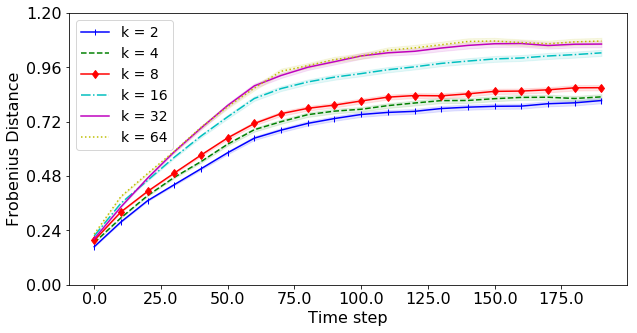

In [24]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#Focusing only on the frobenius norm
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for algorithm, result in results.items():
    jac_err = collect_jacobian_dist(result)
    line_type = line_types[algorithm]
    plot_mu_sig(jac_err[0:200:10, :], label=algorithm, ax=ax, line_stype=line_type)

ax.set_xticklabels(labels = 10* np.arange(-2.5, 20, 2.5))   
ax.get_yaxis().set_ticks(np.linspace(0.0, 1.2, 6))
ax.set_xlabel('Time step')
ax.set_ylabel('Frobenius Distance')
#ax.set_title("Jacobian Differences")
ax.legend()
plt.savefig('{}_multi_pt_jacobian_diff_global.pdf'.format(model),bbox_inches = 'tight',
    pad_inches = 0.1)   

In [25]:
#collects results for plotting histograms and trajectories
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

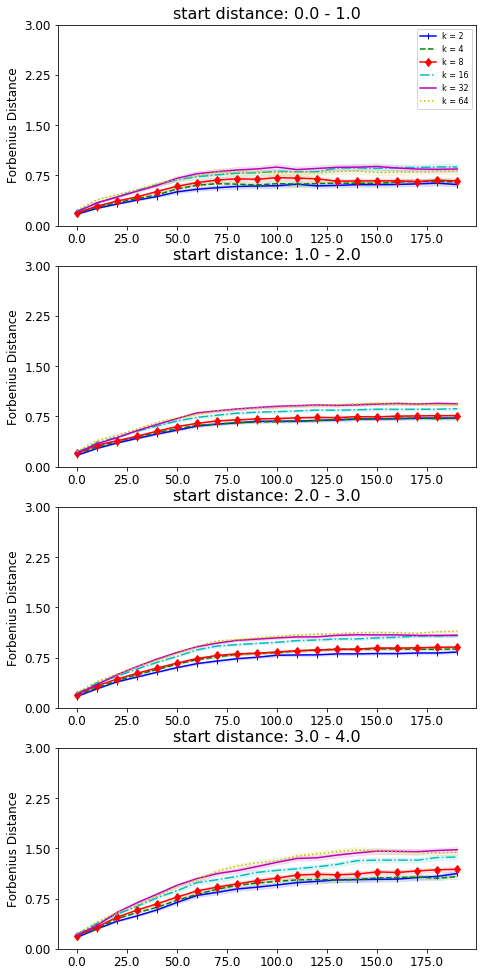

In [26]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bounds = [0.0, 1.0, 2.0, 3.0, 4.0]
fig, axs = plt.subplots(4, 1, figsize=(7.5, 17))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        line_type = line_types[algorithm]
    
        plot_mu_sig(jac_errs[algorithm][0:200:10,to_plot], label=algorithm, ax=ax, line_stype=line_type)
        
    
    
    ax.get_yaxis().set_ticks(np.linspace(0.0, 3.0, 5))
    if i == 0:
        ax.legend()
    ax.set_title("start distance: {} - {}".format(start, end))
    
    #    ax.get_xaxis().set_ticks([])
    if i == 6: 
        ax.set_xlabel("Time step")
    
    ax.set_ylabel("Forbenius Distance")
    ax.set_xticklabels(labels = 10* np.arange(-2.5, 20, 2.5))
    i += 1
    
plt.savefig('multi_pt_jacobian_diff_by_dist.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

# Histograms of Jacobian difference
The previous plots were for trends over trajectories. The Jacobian differences are really independent of timesteps so to get a sense of these differences we visualize the results with histograms 


In [27]:
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

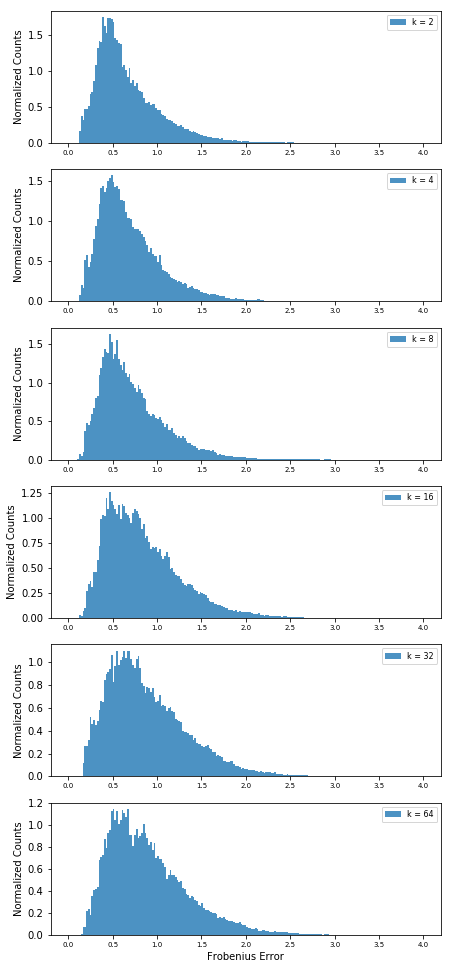

In [28]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE -1)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Focusing only on the frobenius norm
fig, axs = plt.subplots(6, 1, figsize=(7, 17))
axs = np.ndarray.flatten(axs)
i = 0
for algorithm, result in results.items():
    if "Inverse" in algorithm:
        continue
    ax = axs[i]
    i += 1
    jac_err = jac_err = jac_errs[algorithm]
    jac_err = jac_err.flatten()

    ax.hist(jac_err, bins=200, alpha=0.8, density=True, range=(0, 4), label= algorithm)
    ax.legend()
    #ax.set_title(algorithm)
    #if i == 1 or i == 4:
    ax.set_ylabel('Normalized Counts')
    if i == 6:
        ax.set_xlabel("Frobenius Error")

    #    ax.set_xticks([])
    #if i == (len(results) - 1) or i == 4 or i == 6 or i == 5:
    #    ax.set_xlabel('Frobenius Error')

plt.savefig('{}_multi_pt_jacobian_hist.pdf'.format(model),bbox_inches = 'tight',
    pad_inches = 0.1)  

# Check Environment  Conditioning
We just plot the condition numbers of Jacobians in these plots

In [29]:
def check_jacobian_condition(result):
    conditioning_over_time = []
    true_solution_over_time = []
    for k, value in result.items():
        eps_conditioning = []
        true_conditioning = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            #this was backwards.....
            J_hat = v[-2] 
            J = v[-1]
            
            #print("condition numbers:")
            #print("J hat", np.linalg.cond(J_hat), "J", np.linalg.cond(J), "JiJ", np.linalg.cond(JiJ))
            hat_cond = np.linalg.cond(J_hat)
            true_cond = np.linalg.cond(J)
            
            #iJ_hat = np.linalg.pinv(J_hat)
            #JiJ = np.matmul(J, iJ_hat)
            
            #JiJ_cond = np.linalg.cond(JiJ)
            eps_conditioning.append(hat_cond)
            true_conditioning.append(true_cond)
            
        conditioning_over_time.append(eps_conditioning)    
        true_solution_over_time.append(true_conditioning)
    return np.array(conditioning_over_time).T, np.array(true_solution_over_time).T

In [30]:
jac_conds = {}
for i, k_v in enumerate(results.items()):
    algorithm, result = k_v[0], k_v[1]

    cond_hat, cond_true = check_jacobian_condition(result)
    jac_conds[algorithm] = cond_hat

In [31]:
# Checking conditioning of Matrix over episodes & comparing to true jacobian at those points

cond_stats = {}
for i, k_v in enumerate(results.items()):
    algorithm, result = k_v[0], k_v[1]
    #cond_hat, cond_true = check_jacobian_condition(result)
    jac_err = jac_conds[algorithm]
    jac_err = jac_err.flatten()
    print(jac_err.mean(), jac_err.std() )
    cond_stats[algorithm] = {'mean': jac_err.mean(), "standard deviation": jac_err.std()}


cond_table = pd.DataFrame.from_dict(cond_stats).round(3).transpose()
cond_table

95.49473 52.93567
90.25729 48.650867
89.6686 52.883717
94.510185 47.91774
103.277466 56.745914
112.05095 62.22706


,mean,standard deviation
k = 16,94.510,47.918
k = 2,95.495,52.936
k = 32,103.277,56.746
k = 4,90.257,48.651
k = 64,112.051,62.227
k = 8,89.669,52.884
